In [1]:
import CSV
import JLD2

using Distributions
using Plots; pyplot(size=(600, 400))
using StatPlots

In [2]:
include("src/NGSIM.jl")

Base.Nullable{

chmm_em! (generic function with 1 method)

S}, Base.Nullable{T}) in module Base at nullable.jl:238 overwritten in module NullableArrays at C:\Users\Hamza El-Saawy\.julia\v0.6\NullableArrays\src\operators.jl:99.
  likely near In[1]:2
  likely near In[1]:2


In [3]:
DATA_PATH = "../data/trajdata_i101_trajectories-0750am-0805am"
JLD2.@load joinpath(DATA_PATH, "td.jld") td

(S, id_lookup) = td_sparse(td)

X_full = CSV.read(joinpath(DATA_PATH, "X.csv"); nullable=false)
X = Array(X_full[:, [:velocity, :heading, :acceleration]])'
V = hcat(X[1, :] .* sin.(X[2, :]),
         X[1, :] .* cos.(X[2, :]),
         X[3, :] .* sin.(X[2, :]),
         X[3, :] .* cos.(X[2, :]))'

(pairs, _) = readcsv(joinpath(DATA_PATH, "pairs.csv"), Int; header=true)
pairs = pairs'
;

## EM

In [4]:
K = 5
curr = chmm_from_data(V, K)
orig_est = deepcopy(curr)
suff = ChmmSuffStats(curr)
;

In [6]:
(curr, log_like_hist) = chmm_em!(S, V, pairs, K, curr, suff; N_iters=250, print_every=10)
l = round(Int, abs(last(filter(isfinite, log_like_hist))))
JLD2.@save joinpath(DATA_PATH, "chmm_$l.jld") curr
;

iteration     10:  2674708.403
iteration     20:  3082128.781
iteration     30:  3376471.531
iteration     40:  3381856.181
iteration     50:  3382791.843
iteration     60:  3384698.460
iteration     70:  3405813.439
iteration     80:  3551696.859
iteration     90:  4201454.174
iteration    100:  4897293.908
iteration    110:  4973294.920
iteration    120:  4979658.349
iteration    130:  4981363.790
iteration    140:  4981617.529
iteration    150:  4981709.572
iteration    160:  4981756.544
iteration    170:  4981778.574
iteration    180:  4981787.354
iteration    190:  4981791.984
iteration    200:  4981795.570
iteration    210:  4981803.363
iteration    220:  4981808.875
iteration    230:  4981814.301
iteration    240:  4981815.434
iteration    250:  4981815.803


In [6]:
JLD2.@load joinpath(DATA_PATH, "chmm_4981816.jld") curr
;

1-element Array{Symbol,1}:
 :curr


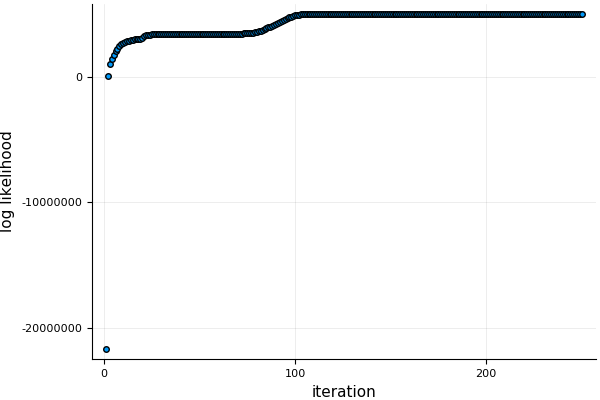

In [7]:
scatter(log_like_hist, legend=false)
ylabel!("log likelihood")
xlabel!("iteration")

In [8]:
@assert all( diff(log_like_hist) .> 0 )

# Analysis (????)


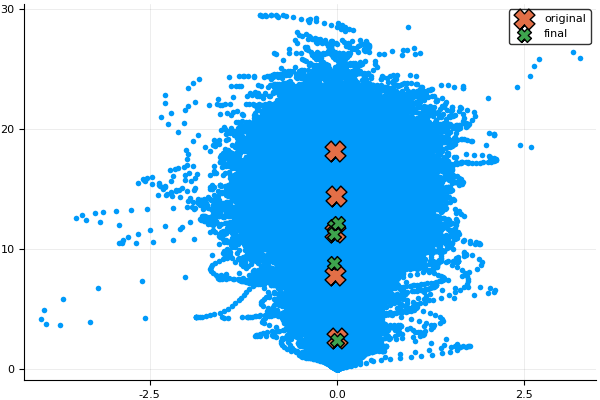

In [13]:
ms = hcat(curr.μs...)'
ms_orig = hcat(orig_est.μs...)'

scatter(V[1, :], V[2, :], label="", marker=(:circle, stroke(0)))
scatter!(ms_orig[:,1], ms_orig[:, 2], marker=:X, ms=15, label="original")
scatter!(ms[:,1], ms[:, 2], marker=:X, ms=10, label="final")

In [14]:
map(display, curr.μs);

4-element Array{Float64,1}:
  0.0017596  
  2.43121    
  0.000280569
 -0.25777    

4-element Array{Float64,1}:
 -0.0364943  
  8.87698    
 -0.000319537
  0.193137   

4-element Array{Float64,1}:
 -0.037947  
 11.9324    
 -0.00185208
  0.689087  

4-element Array{Float64,1}:
 -0.0369974 
 11.2838    
  0.00139848
 -0.59147   

4-element Array{Float64,1}:
  0.00824741
 12.1985    
 -8.6019e-6 
  0.0334356 

In [15]:
map(display, curr.Σs);

4×4 Array{Float64,2}:
  0.000880528   0.00682332   -0.000122562   0.000198975
  0.00682332    4.38922      -0.000936718  -0.704162   
 -0.000122562  -0.000936718   6.75137e-5    0.000571789
  0.000198975  -0.704162      0.000571789   0.592117   

4×4 Array{Float64,2}:
  0.152075    -0.0937897   0.00511929  -0.00481002
 -0.0937897   25.0509     -0.0090219   -0.424137  
  0.00511929  -0.0090219   0.00386008  -0.00157855
 -0.00481002  -0.424137   -0.00157855   1.84397   

4×4 Array{Float64,2}:
  0.0210731   -0.00295614  0.00108141  0.00533331
 -0.00295614  12.8747      0.00128422  0.130038  
  0.00108141   0.00128422  6.68824e-5  1.70846e-5
  0.00533331   0.130038    1.70846e-5  0.0875917 

4×4 Array{Float64,2}:
  0.023537    -0.00293842  -0.00105631  -0.00757483
 -0.00293842   9.91522     -0.00147221  -0.124366  
 -0.00105631  -0.00147221   6.13836e-5   4.93214e-5
 -0.00757483  -0.124366     4.93214e-5   0.0928612 

4×4 Array{Float64,2}:
  0.0169672     0.0162233  4.4631e-5   -0.000275388
  0.0162233    12.4943     0.0001053    0.0389211  
  4.4631e-5     0.0001053  1.60066e-6   5.9143e-5  
 -0.000275388   0.0389211  5.9143e-5    0.0240746  

In [22]:
clibrary(:cmocean)
default_cgrad(:cmocean, default=:deep)

true


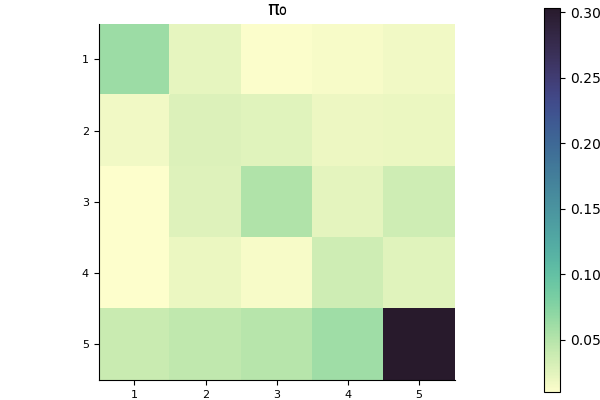

In [23]:
l = map(string, 1:K)
heatmap(l, l, reshape(curr.π0, K, K), aspect_ratio=1, title="π₀")
yaxis!(:flip)


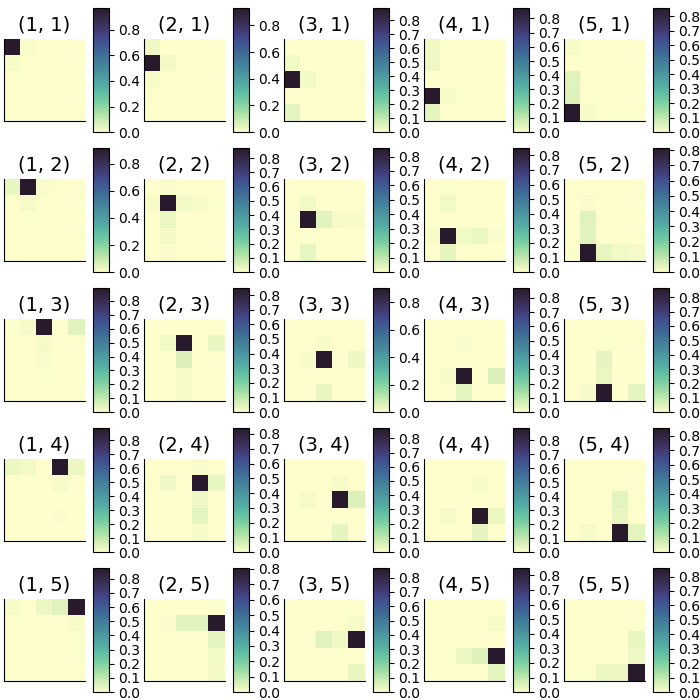

In [24]:
ps = Matrix(K, K)
for i in 1:K
    for j in 1:K
        k = sub2ind((K, K), i, j)
        p = reshape(curr.P[:, k], K, K)
        ps[i,j] = heatmap(l, l, p, title="($i, $j)", aspect_ratio=1)
    end
end
plot(ps..., aspect_ratio=1, palette=:deep, colorbar=true, size=(700, 700))
yaxis!(:flip, ticks=0)